# Прогнозирование цен на дома

## 0. Описание задачи
Цель этого проекта — предсказать цены на дома в зависимости от различных характеристик, таких как площадь, количество комнат, год постройки и т.д. Для этого мы будем использовать алгоритм K-ближайших соседей (KNN), который является простым и эффективным методом регрессии.


In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error


## 1. Прочитать данные

In [4]:
# Загрузка данных
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Отображение первых нескольких строк обучающего набора
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 2. Визуализировать данные и вычислить основные характеристики

                Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  ...  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000  ...   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726  ...   
std       1.112799    30.202904     20.645407   181.066207   456.098091  ..

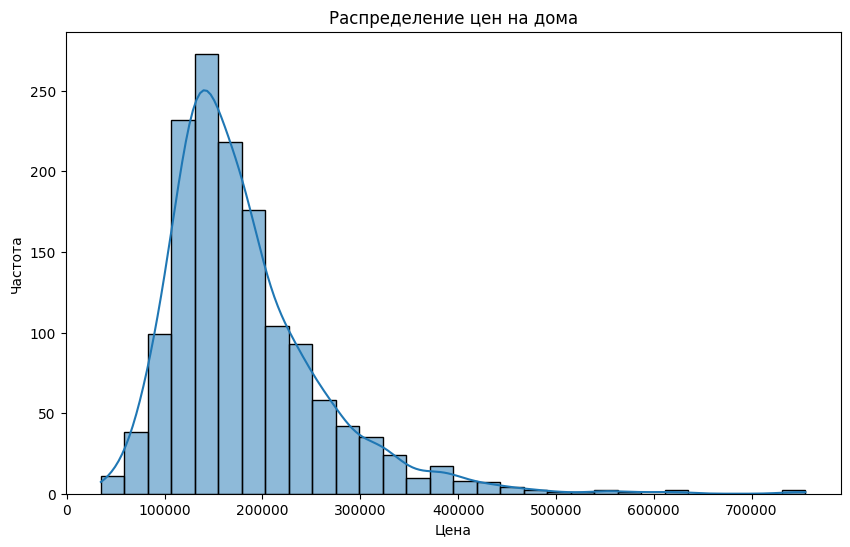

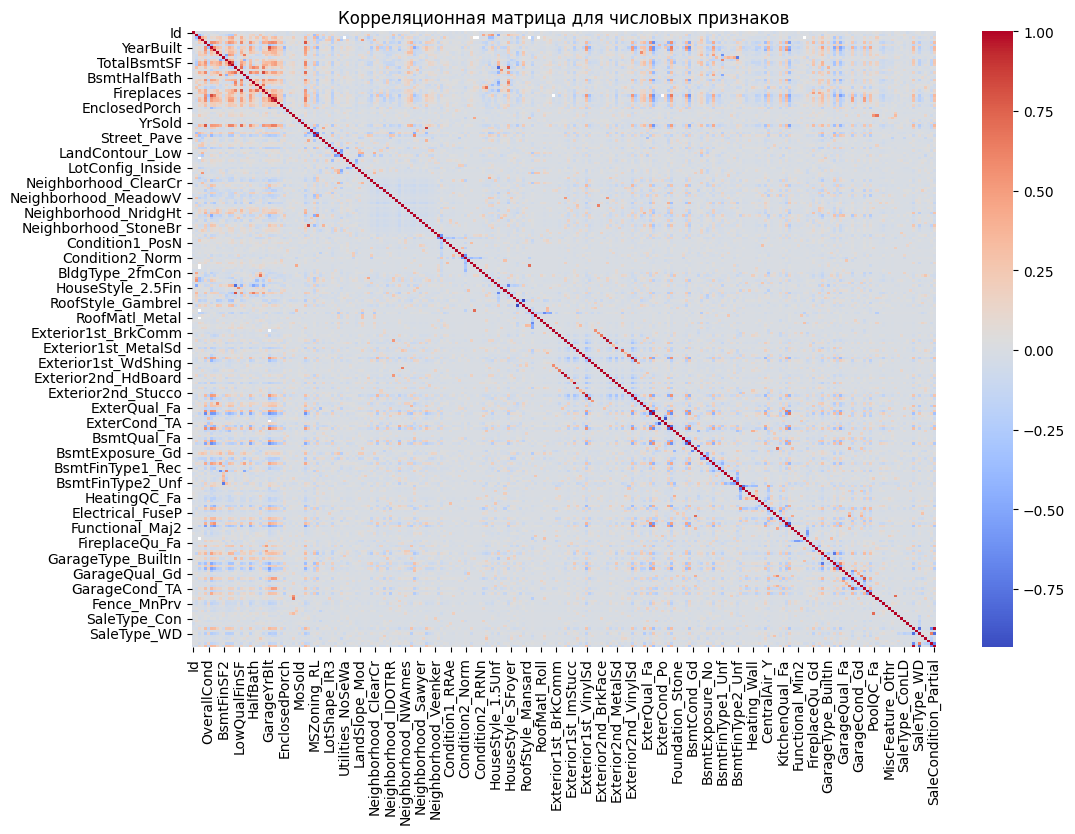

In [5]:
# Описание основных характеристик
print(train_data.describe())

# Визуализация распределения целевой переменной
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], bins=30, kde=True)
plt.title('Распределение цен на дома')
plt.xlabel('Цена')
plt.ylabel('Частота')
plt.show()

# Преобразование категориальных признаков для расчета корреляционной матрицы
train_data_encoded = pd.get_dummies(train_data, drop_first=True)

# Корреляционная матрица
corr_matrix = train_data_encoded.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица для числовых признаков')
plt.show()

## 3. Обработать пропущенные значения

In [7]:
# Проверка на пропуски
missing_data = train_data.isnull().sum()
print('Пропуски в обучающем наборе:\n', missing_data[missing_data > 0])

# Заполнение пропусков
train_data['LotFrontage'] = train_data['LotFrontage'].fillna(train_data['LotFrontage'].median())

Пропуски в обучающем наборе:
 Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


## 4. Обработать категориальные признаки

In [8]:
# One-Hot Encoding категориальных признаков
train_data = pd.get_dummies(train_data, drop_first=True)

## 5. Провести нормализацию

In [9]:
# Нормализация данных
scaler = StandardScaler()
X = train_data.drop(['SalePrice'], axis=1)
y = train_data['SalePrice']
X_scaled = scaler.fit_transform(X)

## 6. Разбить данные на обучающую и тестовую выборки

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## 7. Запустить классификатор K-ближайших соседей

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor

# Создаем объект SimpleImputer для заполнения медианой
imputer = SimpleImputer(strategy='median')

# Применяем его к обучающим данным
X_train_imputed = imputer.fit_transform(X_train)

# Обучаем модель
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_imputed, y_train)


KNeighborsRegressor()

## 8. Вычислить ошибки на обучающей и тестовой выборках

In [14]:
from sklearn.metrics import mean_absolute_error

# Заполняем пропуски в валидационном наборе с использованием обученного импьютера
X_val_imputed = imputer.transform(X_val)

# Предсказываем значения на валидационном наборе
y_val_pred = knn.predict(X_val_imputed)

# Вычисляем среднюю абсолютную ошибку
mae = mean_absolute_error(y_val, y_val_pred)
print(f'Mean Absolute Error на валидационной выборке: {mae:.2f}')


Mean Absolute Error на валидационной выборке: 24927.22


## 9. Запустить другие классификаторы (по желанию)

In [15]:
from sklearn.ensemble import RandomForestRegressor

# Обучение модели Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_val_pred_rf = rf.predict(X_val)
mae_rf = mean_absolute_error(y_val, y_val_pred_rf)
print(f'Mean Absolute Error для Random Forest: {mae_rf:.2f}')

Mean Absolute Error для Random Forest: 17735.18


## 12. Общие выводы

В ходе данного проекта мы провели анализ и предсказание цен на дома с использованием различных методов машинного обучения.

1. **Моделирование с использованием K-ближайших соседей (KNN):** Начальные результаты показали, что модель KNN смогла предоставить прогнозы цен на дома. Однако, как оказалось, более сложные модели, такие как Random Forest, дали более точные результаты.

2. **Использование Random Forest:** Модель Random Forest показала лучшие результаты по сравнению с KNN. Это может быть связано с более сложной структурой деревьев решений в Random Forest, которая позволяет лучше адаптироваться к данным и делать более точные прогнозы.

3. **Обработка пропусков:** Данные содержали значительное количество пропусков. Хотя мы использовали метод заполнения медианой для заполнения пропусков, это может привести к некоторой потере информации. Для улучшения качества прогнозов рекомендуется более тщательная обработка пропусков, например, с использованием более сложных методов заполнения или удаления строк с пропусками.

4. **Дальнейшие шаги:** Для достижения еще более точных прогнозов рекомендуется продолжить экспериментировать с различными предобработками данных и моделями машинного обучения. Это может включать в себя более тщательный анализ корреляций между признаками, использование более сложных методов обработки пропусков, а также применение более продвинутых методов машинного обучения, таких как градиентный бустинг или нейронные сети.

В целом, данный проект предоставил ценные уроки о том, как использовать методы машинного обучения для предсказания цен на дома. Для достижения лучших результатов рекомендуется продолжить экспериментировать с различными предобработками данных и моделями, а также учитывать особенности данных и задачи при выборе подходящего метода машинного обучения.